# How does the gradient evolve during training ?

How does the size of the gradient and its direction evolve during training? 

Note: WORK IN PROGRESS (UNFINISHED)



In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
from tqdm import trange

In [2]:
# switch off annoying tensorflow autograph warning
# (seems a known issue, may depend on tf version; try without it
# and see what happens!)
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [41]:
# our target function:

def F(x):
    return np.sin(4*(x[...,0]+x[...,1]))/(1+np.sum(x**2,axis=-1))

# defining the network:

def get_network(layers,learning_rate=0.01,optimizer=None):
    network=tfk.Sequential([tfk.layers.Dense(n,activation='relu') 
        for n in layers] + [tfk.layers.Dense(1)])
    if optimizer is None:
        optimizer=tfk.optimizers.SGD(learning_rate=learning_rate)
    network.compile(loss='mse', optimizer=optimizer)
    return network

# running the training:

def run_training(network,n_batches=1000,batchsize=30,
    fixed_batch=False, test_batch=None):
    losses=[]
    grad_lengths=[]
    loss_fn=tfk.losses.MeanSquaredError()
    if test_batch is not None:
        test_batch=np.array(test_batch) # if user passes a list, convert to array
        test_results=np.zeros([n_batches]+[test_batch.shape[0],1])
    else:
        test_results=None
    if fixed_batch:
        x=3.0*np.random.randn(batchsize,2)
    for sample in trange(n_batches):
        if not fixed_batch:
            x=3.0*np.random.randn(batchsize,2)
        with tf.GradientTape() as tape:
            output=network(x) # get output of network
            loss=loss_fn(output,F(x)) # get loss
# note that reduce_mean sums over all samples in the batch
# and then divides the result by the batchsize (number of samples)

# now: calculate gradients!
# this will produce a list 'grads', containing gradients of the loss
# with respect to the parameters in each layer
# (each weights and bias set is a separate entry
# in the list, so 2 entries per layer in the list)
        grads=tape.gradient(loss,network.trainable_variables)

# calculate total length of gradient vector (summing Pythagoras)
        grad_length=np.sqrt(sum([tf.reduce_sum(g**2) for g in grads]))
        network.optimizer.apply_gradients(zip(grads,network.trainable_variables))
        if test_batch is not None:
            test_results[sample,...]=network(test_batch) # evaluate on test batch
        losses.append(loss.numpy()) # append loss as number (not tensor)
        grad_lengths.append(grad_length)
    return losses, grad_lengths, test_results

In [32]:
import matplotlib.pyplot as plt

# plot loss curves, gradient length, test results,
# and the network approximation to F(x):
def plot_losses_and_fit(loss,grad_lengths,test_results,
        network,title):
    fig,ax=plt.subplots(ncols=4,figsize=[10,3],dpi=200)
    ax[0].plot(loss,alpha=0.5)
    ax[0].set_yscale("log", base=10)
    ax[0].set_ylim([np.amin(loss[300:])/1.1,loss[300]*1.1]) # reasonable scale
    ax[0].set_title(title)
    ax[1].plot(grad_lengths,alpha=0.5)
    ax[1].set_ylim([0.,grad_lengths[300]*2])
    ax[1].set_title("gradient length")
    npixels=100
    extent=[-3.0,3.0]
    vals=np.linspace(*extent,npixels)
    x=np.zeros([npixels,npixels,2])
    x[...,0],x[...,1]=vals[:,None],vals[None,:]
    n=test_results.shape[0]
    n_results=test_results.shape[1]*test_results.shape[2]
    flattened_test_results=np.reshape(test_results,[n,n_results])
    ax[2].plot(flattened_test_results)
    ax[2].set_ylim([np.amin(flattened_test_results[200:,:]),
        np.amax(flattened_test_results[200:,:])])
    ax[2].set_title("test results")
    ax[3].imshow(network(x).numpy()[...,0],origin='lower', extent=extent + extent)
    plt.show()


In [38]:
# run several different layer configurations, each of them several times (for statistics)
def try_layers(layers,n_batches=5000,batchsize=30,
    print_summary=False,num_trials=1,fixed_batch=False,
    test_batch=None,
    learning_rate=0.1, optimizer=None):
    network=get_network(layers,learning_rate=learning_rate, optimizer=optimizer)
    losses,grad_lengths,test_results=run_training(network=network,
        n_batches=n_batches,batchsize=batchsize,test_batch=test_batch,
        fixed_batch=fixed_batch)
    print("Layers: ", layers, " Final loss: ", losses[-1])
    plot_losses_and_fit(losses,grad_lengths,test_results,
        network,str(layers))
    if print_summary:
        print(network.summary())

 19%|█▉        | 943/5000 [00:03<00:13, 309.73it/s]2021-10-23 20:08:00.921475: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2021-10-23 20:08:00.921681: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2021-10-23 20:08:00.934444: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_

Layers:  [40]  Final loss:  0.03854987770318985


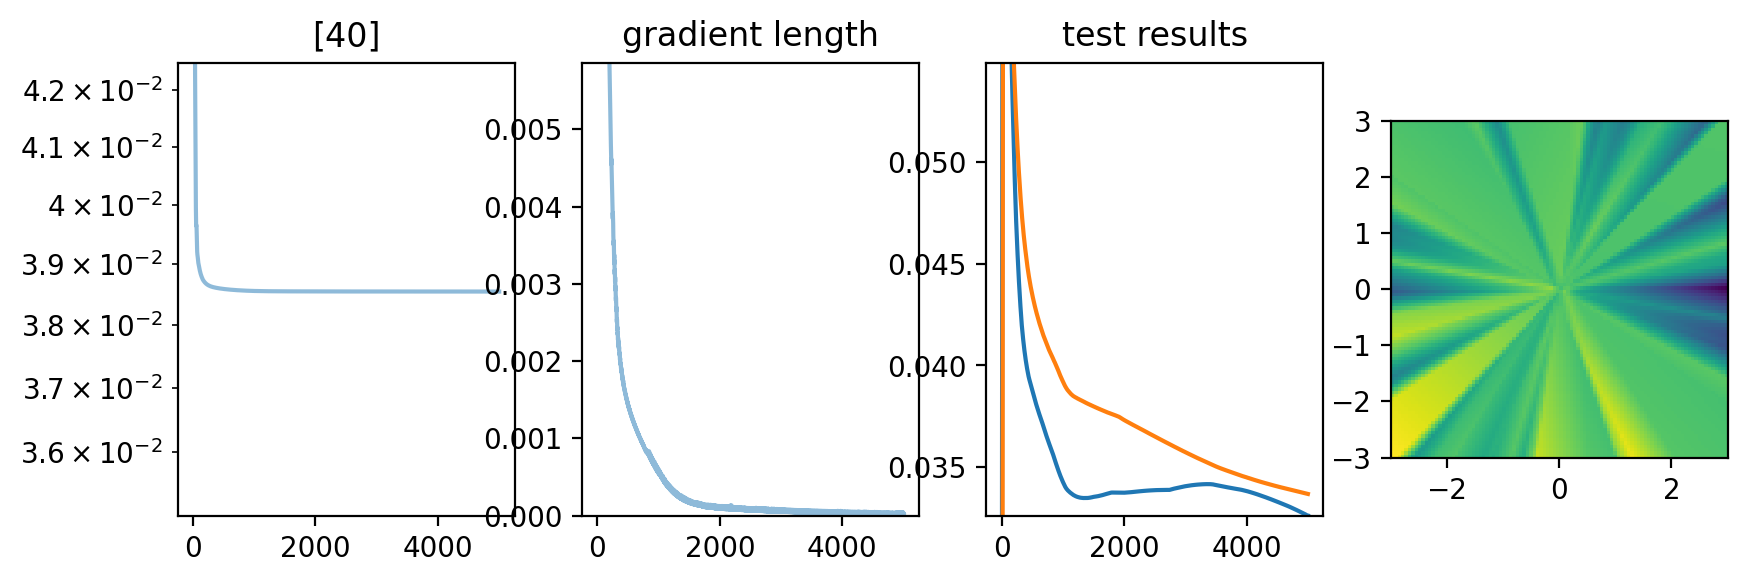

In [42]:
try_layers([40],batchsize=30,
    n_batches=5000,fixed_batch=True,
    test_batch=[[0.0,0.0],[1.0,0.0]],
    optimizer='adam')